# Анализ набора данных перевозок пассажиров и прогнозирование с помощью моделей SARIMAX и Prophet.

Загрузка библиотек и данных.

In [7]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# импортируем файл с данными о пассажирах
passn_p = pd.read_csv("/content/passengers.csv")
passn_p.head(5)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
# превратим дату в индекс и сделаем изменение постоянным
passn = pd.read_csv("/content/passengers.csv", index_col = 'Month', parse_dates = True)
passn.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [9]:
# рассчитаем скользящее среднее для 4 предыдущих месяцев
passn.rolling(window = 4).mean().head(5)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,122.75
1949-05-01,125.00


Построение графика перевозок пассажиров и скользящего среднего за 12 месяцев.

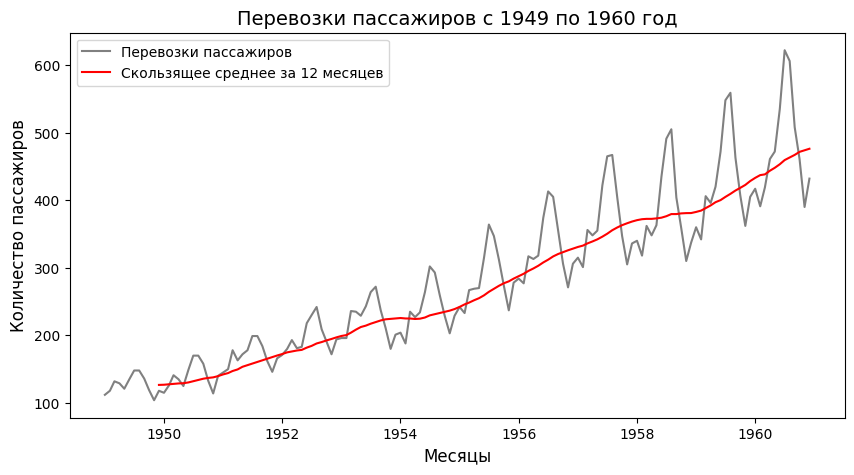

In [10]:
# зададим размер графика
plt.figure(figsize = (10,5))

# зададим кривые (перевозки и скользящее среднее)
plt.plot(passn, label = 'Перевозки пассажиров', color = 'gray')
plt.plot(passn.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'red')
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 10)
# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 12)
plt.ylabel('Количество пассажиров', fontsize = 12)
plt.title('Перевозки пассажиров с 1949 по 1960 год', fontsize = 14)
plt.show()

Разложение временного ряда на компоненты.

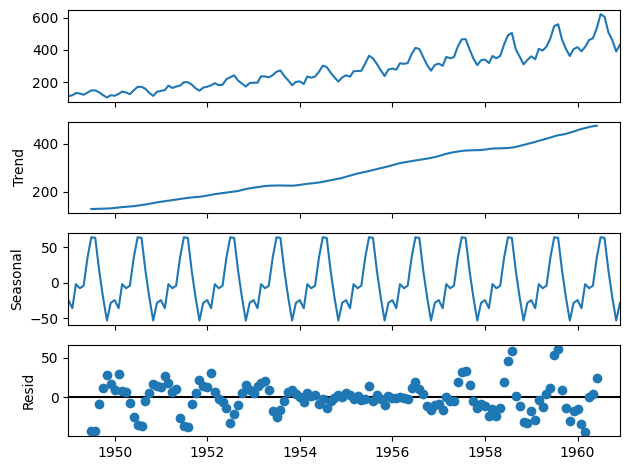

In [11]:
# импортируем функцию seasonal_decompose из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# применяем функцию к данным
decompose = seasonal_decompose(passn)
decompose.plot()
plt.show()

Во временном ряду присутствует нарастающий тренд и сезонность. Далее проверяем ряд на стационарность по тесту Дики-Фуллера.


In [12]:
# импортируем необходимую функцию
from statsmodels.tsa.stattools import adfuller

# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(passn['#Passengers'])
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.991880243437641


Временной ряд нестационарен (p-value > 0.05). Вызовем автокорреляционную функцию (ACF) и функцию частичной автокорреляции (PACF).

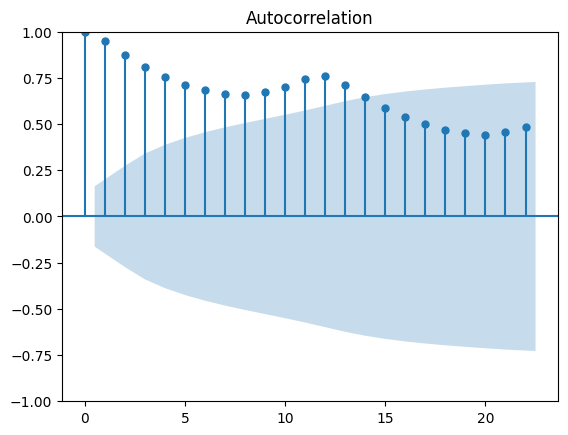

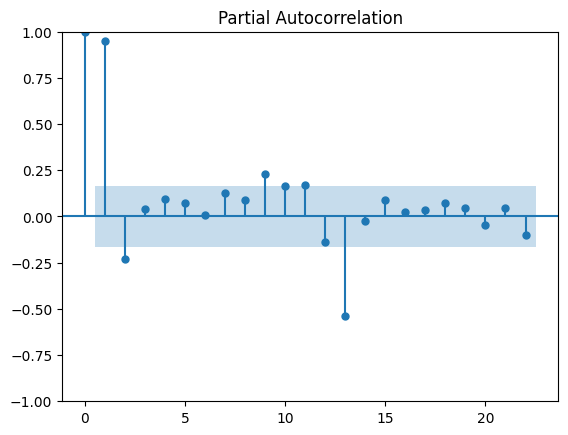

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# построим графики
plot_acf(passn)
plot_pacf(passn)
plt.show()

Автокорреляция позволяет убедиться в наличии сезонных колебаний и тренда. Далее разделим данные на обучающую и тестовую выборки.

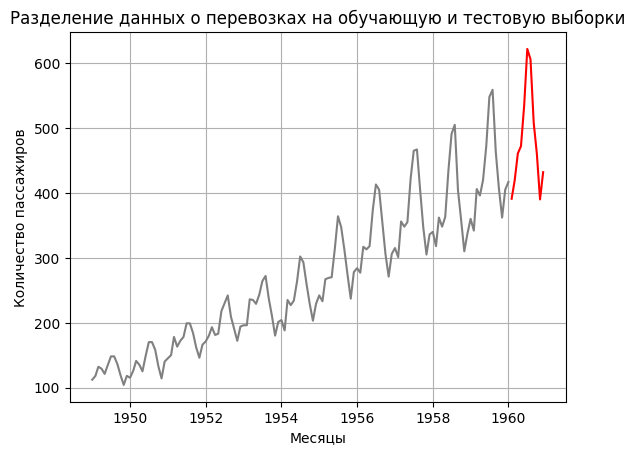

In [45]:
# обучающая выборка будет включать данные до янв 1960 года включительно
train = passn[:'1960-1']
# тестовая выборка начнется с февр 1960 года
test = passn['1960-2':]

# выведем эти данные на графике
plt.plot(train, color = "gray")
plt.plot(test, color = "red")
# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
# добавим сетку
plt.grid()

plt.show()

Вызовем модель SARIMAX. Подберем для нее параметры исходя из графиков ACF и PACF.

In [36]:
import pandas as pd

# отключим предупреждения системы
import warnings
warnings.filterwarnings("ignore")

# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 12)

# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX

passn = pd.read_csv("/content/passengers.csv", index_col = 'Month', parse_dates = True)
# обучающая выборка будет включать данные до янв 1960 года включительно
train = passn[:'1960-1']

# создадим объект этой модели
model = SARIMAX(train,
                order = (3, 0, 0),
                seasonal_order = (0, 1, 0, 12))

# применим метод .fit()
result = model.fit()
# посмотрим результат с помощью метода summary()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  133
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -455.354
Date:                            Thu, 02 Oct 2025   AIC                            918.708
Time:                                    14:08:23   BIC                            929.891
Sample:                                01-01-1949   HQIC                           923.249
                                     - 01-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7526      0.087      8.685      0.000       0.583       0.922
ar.L2          0.2910      0.132   

In [56]:
# тестовый период начнется с конца обучающего периода
start = len(train)
# и закончится в конце тестового
end = len(train) + len(test) - 1

# применим метод .predict() модели sarimax
predictions = result.predict(start, end)
predictions

,predicted_mean
1960-02-01,400.540834
1960-03-01,461.222650
1960-04-01,450.051343
1960-05-01,472.081169
1960-06-01,522.522219
1960-07-01,596.868988
1960-08-01,606.328213
1960-09-01,508.811829
1960-10-01,451.354052
1960-11-01,404.938509


Построение графика тестовой выборки и тестового прогноза.

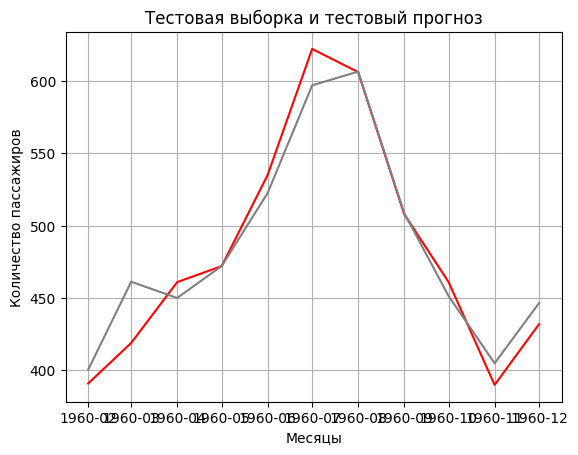

In [57]:
# выведем 2 кривые (тестовая выборка и тестовый прогноз)
plt.plot(test, color = 'red')
plt.plot(predictions, color = 'gray')

# заголовок и подписи к осям
plt.title('Тестовая выборка и тестовый прогноз')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
# добавим сетку
plt.grid()

plt.show()

Посчитаем метрики MSE и RMSE.

In [58]:
# импортируем функции метрик
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# рассчитаем MSE
print(mean_squared_error(test, predictions))

# и RMSE
print(root_mean_squared_error(test, predictions))

300.924840026652
17.347185363241266


Рассчитаем прогноз на два года вперед.

In [59]:
# прогнозный период начнется с конца имеющихся данных
start = len(passn)

# и закончится 24 месяца спустя
end = (len(passn) - 1) + 2 * 12

# теперь построим прогноз на два года вперед
forecast = result.predict(start, end)

# посмотрим на весь 1962 год
forecast[-12:]

,predicted_mean
1962-01-01,484.522491
1962-02-01,465.910354
1962-03-01,524.507725
1962-04-01,511.318490
1962-05-01,531.394711
1962-06-01,579.944460
1962-07-01,652.460230
1962-08-01,660.146843
1962-09-01,560.914368
1962-10-01,501.795221


Постороние графика с фактическими данными и прогнозом на два года.

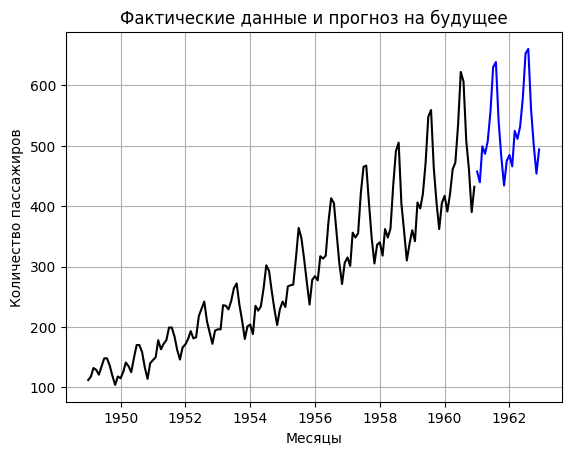

In [60]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(passn, color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
# добавим сетку
plt.grid()

plt.show()

Прогнозирование с помощью модели Prophet.


In [90]:
passn_p = pd.read_csv("/content/passengers.csv")

# преобразуем столбцы датасета
passn_p['ds'] = pd.to_datetime(passn_p['Month'])
passn_p = passn_p.rename(columns={'#Passengers': 'y'})
passn_p = passn_p.drop(['Month'], axis=1)
passn_p.head(5)

,y,ds
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01


In [91]:
# обучающая выборка будет включать данные до янв 1960 года включительно
prediction = 11
train_df = passn_p[:-prediction].copy()
test_df = passn_p[-prediction:].copy()
test_df.head(-5)

,y,ds
133,391,1960-02-01
134,419,1960-03-01
135,461,1960-04-01
136,472,1960-05-01
137,535,1960-06-01
138,622,1960-07-01


Вызовем модель Prophet и построим графики прогнозов.

In [92]:
# импортируем модель prophet и метрики оценки качества
import prophet
from prophet.plot import plot_plotly

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

prophet.diagnostics.logging.disable(level=50)

m = prophet.Prophet()
m.fit(train_df)
# прогноз на 2 года вперед
future = m.make_future_dataframe(periods=24, freq = 'm')
forecast_p = m.predict(future)

plot_plotly(m, forecast_p)

In [93]:
forecast_p.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,109.926232,59.386987,109.722717,109.926232,109.926232,-24.422976,-24.422976,-24.422976,-24.422976,-24.422976,-24.422976,0.0,0.0,0.0,85.503256
1,1949-02-01,112.044960,51.403480,105.072518,112.044960,112.044960,-34.161807,-34.161807,-34.161807,-34.161807,-34.161807,-34.161807,0.0,0.0,0.0,77.883153
2,1949-03-01,113.958650,92.327022,141.181066,113.958650,113.958650,3.111417,3.111417,3.111417,3.111417,3.111417,3.111417,0.0,0.0,0.0,117.070067
3,1949-04-01,116.077378,84.100471,136.524550,116.077378,116.077378,-5.763639,-5.763639,-5.763639,-5.763639,-5.763639,-5.763639,0.0,0.0,0.0,110.313739
4,1949-05-01,118.127760,88.342035,139.310343,118.127760,118.127760,-5.238856,-5.238856,-5.238856,-5.238856,-5.238856,-5.238856,0.0,0.0,0.0,112.888904


In [94]:
v_fb_df = test_df.copy()
v_fb_df['yhat'] = forecast_p['yhat'].iloc[-24:-12]
v_fb_df.head(10)

,y,ds,yhat
133,391,1960-02-01,431.992118
134,419,1960-03-01,453.219168
135,461,1960-04-01,443.256632
136,472,1960-05-01,452.175402
137,535,1960-06-01,484.949417
138,622,1960-07-01,535.669650
139,606,1960-08-01,533.225966
140,508,1960-09-01,483.120208
141,461,1960-10-01,446.627935
142,390,1960-11-01,415.484017


Построим график с тестовыми данными и прогнозами моделей Prophet и SARIMAX.

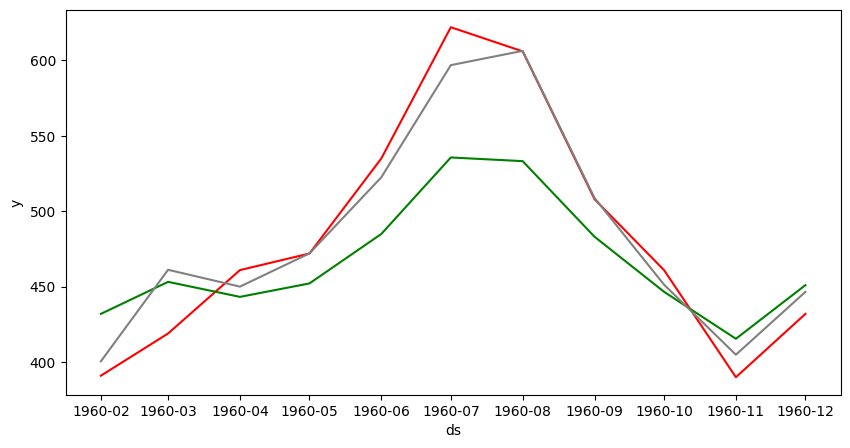

In [95]:
import seaborn as sns

plt.figure(figsize=(10, 5))

sns.lineplot(data=v_fb_df, x='ds', y='y', color = 'red')
sns.lineplot(data=v_fb_df, x='ds', y='yhat', color = 'green')
sns.lineplot(data=predictions, color = 'gray')

plt.show()

Расчитаем метрики качества модели Prophet.

In [96]:
np.sqrt(mean_squared_error(v_fb_df['y'], v_fb_df['yhat']))

np.float64(43.328793360435064)

In [97]:
mean_absolute_percentage_error(v_fb_df['y'], v_fb_df['yhat'])

0.07354864726953865